In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
import analyze_utils

save_dir = '/home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels'

r = analyze_utils.load_results_and_cache_autoprompt_json(save_dir, save_file='r.pkl')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 71.33it/s]


In [3]:
top_prompts = (
    r.groupby(['task_name', 'seed', 'max_digit'])
).first().reset_index()
top_prompts[['task_name', 'seed', 'max_digit', 'prefixes']]

,task_name,seed,max_digit,prefixes
0,add_two,1,10,Input two positive integer values
1,add_two,1,20,Write a function'sum
2,add_two,1,40,_Write a function called sum
3,add_two,1,80,"""Write a program that will"
4,add_two,1,160,_Write a program that reads
...,...,...,...,...
145,subtract_two,3,10,Write a function named sum
146,subtract_two,3,20,1 Given 2 Prompt 3 <
147,subtract_two,3,40,Write a function that takes
148,subtract_two,3,80,"Given 3 positive integers a,"


In [4]:
assert r['checkpoint'].unique()[0] == "EleutherAI/gpt-j-6B"

In [5]:
from iprompt import prompt_classification

model = prompt_classification.create_model(r['checkpoint'].unique()[0])

2023-01-17 15:40:20.579743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 15:40:20.761782: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-17 15:40:20.798810: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-17 15:40:21.879204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [ ]:
## Compute accuracy given correct prompt and save for each task.
import argparse
from tqdm.notebook import tqdm
from iprompt.data import get_data


data = []
print('calculating accs...')
n_shots = 1
batch_size = 16

"""
task_name: str = 'add_two',
 n_shots: int = 1,
 train_split_frac: float = None,
 max_dset_size: int = 10000,
 template_num_task_phrasing: int = 0,
 max_digit: int = 10,
 """

for _, output in tqdm(top_prompts.iterrows(), total=len(top_prompts)):
    args = argparse.Namespace(**output)
    (dset, dset_test), check_answer_func, descr = get_data(
        args.task_name, n_shots=n_shots, train_split_frac=args.train_split_frac,
        max_dset_size=args.max_dset_size, template_num_task_phrasing=0,
        max_digit=args.max_digit,
    )
    # if task_name == 'task107_splash_question_to_sql':
    #     batch_size = max(1, batch_size//4)
    ####   Manual prompt  ####
    manual_loss, manual_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=descr, multi_token=False, verbose=False,
        batch_size=batch_size,
    )
    ####   iPrompt prompt   ####
    iprompt_loss, iprompt_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=output['prefixes'], multi_token=False, verbose=False,
        batch_size=batch_size,
    )
    ####
    output['manual_acc'] = manual_acc
    output['iprompt_acc'] = iprompt_acc
    data.append(output)

calculating accs...


  0%|          | 0/150 [00:00<?, ?it/s]

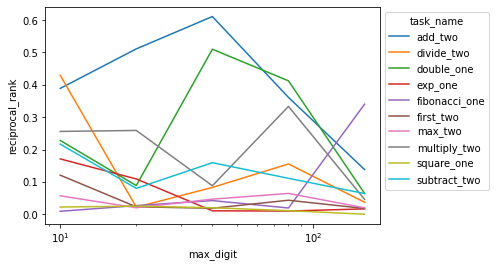

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

r_grouped_by_task = (

    r.groupby(['max_digit', 'seed', 'task_name']).first()
     .groupby(['max_digit', 'task_name']).mean()
     .reset_index()
)

ax = sns.lineplot(
    data=r_grouped_by_task, x='max_digit', y='reciprocal_rank', hue='task_name',
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # legend outside of plot
plt.xscale('log')